# Video Classification with a CNN-RNN Architecture

In [1]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import os

from os import listdir
from os.path import isfile, join
import cv2
import random
from tensorflow_docs.vis import embed
from pathlib import Path

from keras.applications.vgg16 import VGG16

In [17]:
#specify the path to the dataset
traindir = r"C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinetics700\train"
valdir = r"C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinetics700\val"
## Data preparation

IMG_SIZE = 224

In [18]:
def extract_url_labels(dir):
    #create an empty pandas dataframe
    df = pd.DataFrame({'url': [], 'label': []})
    actions_dir = listdir(dir)
    for tmpdir in actions_dir:
        print(tmpdir)
        Lfiles = listdir(dir+"\\"+tmpdir)
        #print(Lfiles)
        for video in Lfiles:
            df.loc[len(df)] = [dir + "\\"+ tmpdir +"\\"+ video, tmpdir]
    return(df)

In [19]:
train_df =extract_url_labels(traindir)
train_df

applauding
cleaning toilet
doing nails
opening bottle (not wine)
petting cat
pillow fight
playing cards
playing guitar
smoking
stretching arm
vacuuming floor
washing dishes


,url,label
0,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
1,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
2,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
3,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
4,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
...,...,...
9664,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
9665,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
9666,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
9667,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes


In [20]:
train_df=train_df.sample(frac=1).reset_index(drop=True)
train_df

,url,label
0,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,petting cat
1,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,pillow fight
2,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
3,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,pillow fight
4,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,playing guitar
...,...,...
9664,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,vacuuming floor
9665,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,playing cards
9666,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,playing cards
9667,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes


In [21]:
val_df = extract_url_labels(valdir)
val_df

applauding
cleaning toilet
doing nails
opening bottle (not wine)
petting cat
pillow fight
playing cards
playing guitar
smoking
stretching arm
vacuuming floor
washing dishes


,url,label
0,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
1,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
2,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
3,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
4,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,applauding
...,...,...
575,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
576,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
577,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
578,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes


In [22]:
val_df=val_df.sample(frac=1).reset_index(drop=True)
val_df

,url,label
0,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,stretching arm
1,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,pillow fight
2,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,opening bottle (not wine)
3,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,opening bottle (not wine)
4,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,smoking
...,...,...
575,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes
576,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,playing guitar
577,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,doing nails
578,C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinet...,washing dishes


In [23]:
print("nombre de vidéos au total (train+validation) : "+ str(len(train_df)+len(val_df)))

nombre de vidéos au total (train+validation) : 10249


In [24]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [25]:
def frames_from_video_file(video_path, n_frames, output_size = (IMG_SIZE, IMG_SIZE), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [55]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

video_path = np.random.choice(train_df["url"].values.tolist())
print(f"Test video path: {video_path}")
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape
print(len(sample_video))

Test video path: C:\Users\louis\Desktop\Cours\IA\ProjetM1\kinetics700\train\applauding\LsXj3sERk3s_000005_000015.mp4
10



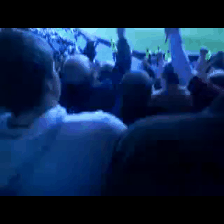

In [56]:
to_gif(sample_video)

In [34]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

['applauding', 'cleaning toilet', 'doing nails', 'opening bottle (not wine)', 'petting cat', 'pillow fight', 'playing cards', 'playing guitar', 'smoking', 'stretching arm', 'vacuuming floor', 'washing dishes']


In [29]:
VGG_model = VGG16(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def exctract_features(video_path):
    frames = frames_from_video_file(video_path, n_frames = 10)
    features = np.zeros(shape=(10, 512), dtype="float32")
    
    for i, img in enumerate(frames):
        img = np.expand_dims(img, axis=0)
        img = keras.applications.vgg16.preprocess_input(img)
        features[i] = VGG_model.predict(img)

    return features

def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["url"].values.tolist()
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_features = np.zeros(
        shape=(num_samples, 10, 512), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frame_features[idx] = exctract_features(path)

    return frame_features, labels

df = pd.DataFrame({'frame_features': [], 'label': []})
    actions_dir = listdir(dir)
    for tmpdir in actions_dir:
        print(tmpdir)
        Lfiles = listdir(dir+"\\"+tmpdir)
        #print(Lfiles)
        for video in Lfiles:
            df.loc[len(df)] = [dir + "\\"+ tmpdir +"\\"+ video, tmpdir]
    return(df)


train_data, train_labels = prepare_all_videos(train_df)
val_data, val_labels = prepare_all_videos(val_df)

In [ ]:
drop_out=0.2

cnn_model = tf.keras.models.Sequential([

    tf.keras.layers.Dense(512, input_shape=[None, 512]),
    tf.keras.layers.Dropout(drop_out),

    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(drop_out),

    tf.keras.layers.Dense(96),
    tf.keras.layers.Dropout(drop_out),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(drop_out),
    
])


# créer le modèle RNN
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
])

# combiner les modèles CNN et RNN
combined_model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(cnn_model, input_shape=[None, 512]),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    rnn_model,
    tf.keras.layers.Dense(11, activation='softmax'),
])

# compiler le modèle
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# afficher les détails du modèle
combined_model.summary()